# Working with tabular data in Python

One of the foundational parts of any astronomical data analysis workflow is the input, output, and manipulation of tables of data.  This can range from collating the results of other analysis to downloading/exploring large catalogs of data to formatting LaTeX tables in manuscripts for publication.  

The astropy [Table](http://docs.astropy.org/en/stable/table/index.html) class provides an extension of NumPy structured arrays for storing and manipulating heterogeneous tables of data. A few notable features of this package are:

- Initialize a table from a wide variety of input data structures and types.
- Modify a table by adding or removing columns, changing column names, or adding new rows of data.
- Handle tables containing missing values.
- Include table and column metadata as flexible data structures.
- Specify a description, units and output formatting for columns.
- Perform operations like database joins, concatenation, and grouping.
- Manipulate multidimensional columns.
- Methods for Reading and writing Table objects to files
- Integration with Astropy [Units and Quantities](http://astropy.readthedocs.org/en/stable/units/index.html)

Tables vs. Pandas DataFrames
--------------

The [Pandas](http://pandas.pydata.org/pandas-docs/stable/) package provides a powerful, high-performance table object via the [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame) class.  Unfortunately, there are a few shortcomings that prevent its use as a generalized table object in astronomy.  The most crucial is lack of support for multidimensional table columns.  This is commonly used in standard FITS data products, for instance the Chandra energy response matrix used to analyze spectral data.  Pandas DataFrame functionality is still very complementary to astropy Tables so astropy 1.1 and later provides interfaces for converting between astropy Tables and DataFrames. If you wish to learn more about Pandas, there are many resources available on-line.  A good starting point is the main tutorials site at http://pandas.pydata.org/pandas-docs/stable/tutorials.html.

Documentation
-------------

For more information about the features presented below, you can read the
[astropy.table](http://docs.astropy.org/en/stable/table/index.html) docs.

*****
*****

Tutorial
===========

In [1]:
from __future__ import print_function, division
from astropy.table import Table

import numpy as np
import matplotlib
from matplotlib import style
style.use('ggplot')  
matplotlib.use('nbagg')  # required for interactive plotting
import matplotlib.pyplot as plt

Creating tables
---------------

There is great deal of flexibility in the way that a table can be initially constructed:

- Read an existing table from a file or web URL
- Add columns of data one by one
- Add rows of data one by one
- From an existing data structure in memory:

  - List of data columns
  - Dict of data columns
  - List of row dicts
  - Numpy homgeneous array or structured array
  - List of row records
  
See the documentation section on [Constructing a table](http://astropy.readthedocs.org/en/stable/table/construct_table.html) for the gory details and plenty of examples.

In [40]:
t = Table()
t['name'] = ['larry', 'curly', 'moe', 'shemp']
t['flux'] = [1.2, 2.2, 3.1, 4.3]

### Looking at your table

In IPython notebook, showing a table will produce a nice HTML representation of the table:

In [41]:
t

name,flux
str5,float64
larry,1.2
curly,2.2
moe,3.1
shemp,4.3


If you did the same in a terminal session you get a different view that isn't as pretty but does give a bit more information about the table:

    >>> t
    <Table rows=4 names=('name','flux')>
    array([('source 1', 1.2), ('source 2', 2.2), ('source 3', 3.1),
           ('source 4', 4.3)], 
          dtype=[('name', 'S8'), ('flux', '<f8')])

To get a plain view which is the same in notebook and terminal use `print()`:

In [4]:
print(t)

 name flux
----- ----
larry  1.2
curly  2.2
  moe  3.1
shemp  4.3


To get the table column names and data types using the `colnames` and `dtype` properties:

In [5]:
t.colnames

['name', 'flux']

In [6]:
t.dtype

dtype([('name', '<U5'), ('flux', '<f8')])

Astropy 1.1 and later provides a ``show_in_notebook()`` method that allows more interactive exploration of tables. It can be especially handy for large tables. 

In [7]:
t.show_in_notebook()

name,flux
larry,1.2
curly,2.2
moe,3.1
shemp,4.3


### Accessing parts of the table

We can access the columns and rows as for numpy structured arrays.  Notice that the outputs are `Column`, `Row` or `Table` objects depending on the context.

In [8]:
t['flux']  # Flux column (notice meta attributes)

1.2
2.2
3.1
4.3


In [9]:
t['flux'][1]  # Row 1 of flux column

2.2000000000000002

In [10]:
t[1]  # Row obj for with row 1 values

name,flux
str5,float64
curly,2.2


In [11]:
t[1]['flux']  # Flux column of row 1

2.2000000000000002

In [12]:
t[1:3]  # 2nd and 3rd rows in a new table

name,flux
str5,float64
curly,2.2
moe,3.1


In [13]:
t[[1, 3]]

name,flux
str5,float64
curly,2.2
shemp,4.3


**One of the most powerful concepts is using boolean selection masks to filter tables**

In [14]:
mask = t['flux'] > 3.0  # Define boolean mask for all flux values > 3
t[mask]  # Create a new table with only the "high flux" sources

name,flux
str5,float64
moe,3.1
shemp,4.3


### Modifying the table

Once the table exists with defined columns there are a number of ways to modify the table in place.  These are fully documented in the section [Modifying a Table](http://astropy.readthedocs.org/en/stable/table/modify_table.html#modifying-a-table).

To give a couple of simple examples, you can add rows with the [add_row()](http://astropy.readthedocs.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.add_row) method or add new columns using dict-style assignment:

In [15]:
t.add_row(('joe', 10.1))  # Add a new source at the end
t['logflux'] = np.log10(t['flux'])  # Compute the log10 of the flux
t

name,flux,logflux
str5,float64,float64
larry,1.2,0.0791812460476
curly,2.2,0.342422680822
moe,3.1,0.491361693834
shemp,4.3,0.63346845558
joe,10.1,1.00432137378


Notice that the `logflux` column really has too many output digits given the precision of the input values.  We can fix this by setting the format using normal Python formatting syntax:

In [16]:
t['flux'].format = '%.2f'
t['logflux'].format = '%.2f'
t

name,flux,logflux
str5,float64,float64
larry,1.20,0.08
curly,2.20,0.34
moe,3.10,0.49
shemp,4.30,0.63
joe,10.10,1.00


### Converting the table to numpy

Sometimes you may not want or be able to use a `Table` object and prefer to work with a plain numpy array.  This is easily done by passing the table to the `np.array()` constructor.  

*This makes a copy of the data*.  If you have a huge table and don't want to waste memory, supply `copy=False` to the constructor, but be warned that changing the output numpy array will change the original table.

In [17]:
np.array(t)

array([('larry', 1.2, 0.07918124604762482),
       ('curly', 2.2, 0.3424226808222063),
       ('moe', 3.1, 0.4913616938342727),
       ('shemp', 4.3, 0.6334684555795865),
       ('joe', 10.1, 1.0043213737826426)], 
      dtype=[('name', '<U5'), ('flux', '<f8'), ('logflux', '<f8')])

Masked tables
-------------

In [18]:
t2 = Table([['x', 'y', 'z'], 
            [1.1, 2.2, 3.3]],
           names=['name', 'value'],
           masked=True)
t2

name,value
str1,float64
x,1.1
y,2.2
z,3.3


In [19]:
t2['value'].mask = [False, True, False]

In [20]:
print(t2)

name value
---- -----
   x   1.1
   y    --
   z   3.3


In [ ]:
t2['value'].fill_value = -99
print(t2.filled())

High-level table operations
----------------------------

So far we've just worked with one table at a time and viewed that table as a monolithic entity.  Astropy also supports high-level [Table operations](http://astropy.readthedocs.org/en/stable/table/operations.html) that manipulate multiple tables or view one table as a collection of sub-tables (groups).

 Documentation	                                                                         | Description
---------------------------------------------------------------------------------------- |-----------------------------------------
[Grouped operations](http://astropy.readthedocs.org/en/stable/table/operations.html#id2) | Group tables and columns by keys
[Stack vertically](http://astropy.readthedocs.org/en/stable/table/operations.html#id3)   | Concatenate input tables along rows
[Stack horizontally](http://astropy.readthedocs.org/en/stable/table/operations.html#id4) | Concatenate input tables along columns
[Join](http://astropy.readthedocs.org/en/stable/table/operations.html#join)              | Database-style join of two tables

Here we'll just introduce the join operation but go into more detail on the others in the exercises.

In [21]:
from astropy.table import join

Now recall our original table `t`:

In [22]:
t

name,flux,logflux
str5,float64,float64
larry,1.20,0.08
curly,2.20,0.34
moe,3.10,0.49
shemp,4.30,0.63
joe,10.10,1.00


Now say that we now got some additional flux values from a different reference for a different, but overlapping sample of sources:

In [23]:
t2 = Table()
t2['name'] = ['larry', 'moe', 'groucho']
t2['flux2'] = [1.4, 3.5, 8.6]

Now we can get a master table of flux measurements which are joined matching the values the `name` column.  This includes every row from each of the two tables, which is known as an **`outer`** join.

In [24]:
t3 = join(t, t2, keys=['name'], join_type='outer')
print(t3)

  name   flux logflux flux2
------- ----- ------- -----
  curly  2.20    0.34    --
groucho    --      --   8.6
    joe 10.10    1.00    --
  larry  1.20    0.08   1.4
    moe  3.10    0.49   3.5
  shemp  4.30    0.63    --


In [25]:
np.mean(t3['flux2'])

4.5

Alternately we could choose to keep only rows where both tables had a valid measurement using an **`inner`** join:

In [26]:
join(t, t2, keys=['name'], join_type='inner')

name,flux,logflux,flux2
str7,float64,float64,float64
larry,1.20,0.08,1.4
moe,3.10,0.49,3.5


Writing data
------------

In [45]:
t3.write('test.fits', overwrite=True)

In [47]:
t3.write('test.vot', format='votable', overwrite=True)
!head test.vot

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 1.1
     http://www.astropy.org/ -->
<VOTABLE version="1.2" xmlns="http://www.ivoa.net/xml/VOTable/v1.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.2">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="name" arraysize="7" datatype="unicodeChar" name="name"/>
   <FIELD ID="flux" datatype="double" name="flux"/>
   <FIELD ID="logflux" datatype="double" name="logflux"/>
   <FIELD ID="flux2" datatype="double" name="flux2"/>


Reading data
------------

You can read data using the [Table.read()](http://astropy.readthedocs.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.read) method:

In [46]:
t4 = Table.read('test.fits')
t4

name,flux,logflux,flux2
str7,float64,float64,float64
curly,2.2,0.342422680822,nan
groucho,nan,nan,8.6
joe,10.1,1.00432137378,nan
larry,1.2,0.0791812460476,1.4
moe,3.1,0.491361693834,3.5
shemp,4.3,0.63346845558,nan


Some formats, such as FITS and HDF5, are automatically identified by file extention while most others will require ``format`` to be explicitly provided. A number of common ascii formats are supported such as IPAC, sextractor, daophot, and CSV. Refer to the documentation for a full listing. 

In [30]:
Table.read?

In [31]:
!head data/2mass.tbl

\fixlen = T
\primary    = 0
\RowsRetrieved =              23938  
\QueryTime     =   00:00:38.68672              
\ORIGIN  = 'IPAC Infrared Science Archive (IRSA), Caltech/JPL'
\DATETIME= '2009-04-15 18:46:00'
\DataTag = 'ADS/IRSA.Gator#2009/0415/184600_12519'
\DATABASE= '2MASS All-Sky Point Source Catalog (PSC) (fp_psc)'
\EQUINOX = 'J2000'
\SKYAREA = 'within 1000 arcsec of  ra=274.70073 dec=-13.80723 Eq J2000 '


In [51]:
t_2mass = Table.read("data/2mass.tbl", format="ascii.ipac")

<IPython.core.display.Javascript object>


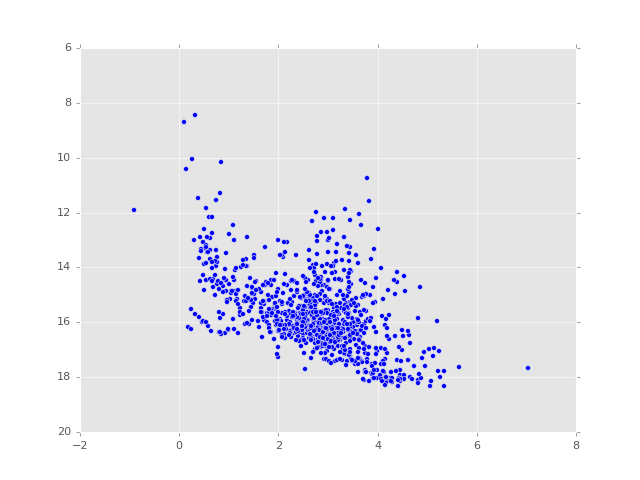

In [33]:
t_2mass['JmK'] = t_2mass['j_m'] - t_2mass['k_m']
plt.figure()
plt.scatter(t_2mass['JmK'], t_2mass['j_m'])
plt.gca().invert_yaxis()
plt.show()

## Working with Pandas
Astropy 1.1 includes new `to_pandas()` and `from_pandas()` [methods](http://docs.astropy.org/en/stable/table/pandas.html)  that facilitate conversion to/from [pandas](http://pandas.pydata.org) `DataFrame` objects.  There are a few caveats in making these conversions:
 - Tables with multi-dimensional columns cannot be converted.
 - Masked values are converted to `numpy.nan`. Numerical columns, int or float, are thus converted to ``numpy.float`` while string columns with missing values are converted to object columns with ``numpy.nan`` values to indicate missing or masked data. Therefore, one cannot always round-trip between `Table` and `DataFrame`.

In [35]:
import pandas as pd
pd_2mass = t_2mass.to_pandas()
pd_2mass

,ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,...,bl_flg,cc_flg,ndet,gal_contam,mp_flg,dist,angle,j_h,h_k,j_k
0,274.429506,-13.870547,18h17m43.08s,-13d52m13.97s,0.08,0.08,45,18174308-1352139,16.305,0.142,...,111,0ss,066655,0,0,975.080151,256.448,2.257,0.791,3.048
1,274.423821,-13.869740,18h17m41.72s,-13d52m11.06s,0.06,0.06,90,18174171-1352110,14.802,0.058,...,111,0ss,666666,0,0,993.752042,256.878,2.167,0.867,3.034
2,274.424587,-13.739629,18h17m41.90s,-13d44m22.66s,0.08,0.08,45,18174190-1344226,16.328,NaN,...,011,0cc,003666,0,0,995.726698,284.113,NaN,0.940,NaN
3,274.433933,-13.769502,18h17m44.14s,-13d46m10.21s,0.08,0.08,45,18174414-1346102,16.281,0.098,...,111,000,065566,0,0,942.627418,278.252,2.224,1.101,3.325
4,274.437013,-13.885698,18h17m44.88s,-13d53m08.51s,0.09,0.09,45,18174488-1353085,15.171,NaN,...,022,0cc,005566,0,0,964.105389,252.930,NaN,0.670,NaN
5,274.433996,-13.752446,18h17m44.16s,-13d45m08.81s,0.08,0.08,90,18174415-1345088,16.540,NaN,...,011,0cc,005666,0,0,953.230532,281.908,NaN,0.915,NaN
6,274.418138,-13.772150,18h17m40.35s,-13d46m19.74s,0.08,0.08,90,18174035-1346197,17.980,NaN,...,011,000,001645,0,0,996.047248,277.250,NaN,1.154,NaN
7,274.433695,-13.899049,18h17m44.09s,-13d53m56.58s,0.06,0.06,90,18174408-1353565,13.011,0.021,...,111,000,666666,0,0,990.166399,250.466,2.094,0.904,2.998
8,274.425482,-13.771490,18h17m42.12s,-13d46m17.36s,0.08,0.08,135,18174211-1346173,16.086,NaN,...,012,00c,005555,0,0,970.896919,277.582,NaN,1.206,NaN
9,274.433057,-13.784866,18h17m43.93s,-13d47m05.52s,0.11,0.11,45,18174393-1347055,18.027,NaN,...,001,000,000006,0,0,939.279823,274.885,NaN,NaN,NaN


In [36]:
t_pd = Table.from_pandas(pd_2mass)
t_pd.show_in_notebook()

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,dist,angle,j_h,h_k,j_k
274.429506,-13.870547,18h17m43.08s,-13d52m13.97s,0.08,0.08,45.0,18174308-1352139,16.305,0.142,0.143,6.7,14.048,0.107,0.108,13.6,13.257,0.066,0.066,16.5,CAA,222,111,0ss,066655,0.0,0.0,975.080151,256.448,2.257,0.791,3.048
274.423821,-13.86974,18h17m41.72s,-13d52m11.06s,0.06,0.06,90.0,18174171-1352110,14.802,0.058,0.059,26.7,12.635,0.059,0.06,50.1,11.768,0.045,0.046,65.2,AAA,222,111,0ss,666666,0.0,0.0,993.752042,256.878,2.167,0.867,3.034
274.424587,-13.739629,18h17m41.90s,-13d44m22.66s,0.08,0.08,45.0,18174190-1344226,16.328,--,--,--,14.345,0.059,0.06,10.4,13.405,0.046,0.047,14.4,UAA,022,011,0cc,003666,0.0,0.0,995.726698,284.113,--,0.94,--
274.433933,-13.769502,18h17m44.14s,-13d46m10.21s,0.08,0.08,45.0,18174414-1346102,16.281,0.098,0.099,6.8,14.057,0.035,0.036,13.5,12.956,0.032,0.033,21.8,CAA,222,111,000,065566,0.0,0.0,942.627418,278.252,2.224,1.101,3.325
274.437013,-13.885698,18h17m44.88s,-13d53m08.51s,0.09,0.09,45.0,18174488-1353085,15.171,--,--,--,14.412,0.152,0.152,9.8,13.742,0.095,0.095,10.6,UBA,622,022,0cc,005566,0.0,0.0,964.105389,252.93,--,0.67,--
274.433996,-13.752446,18h17m44.16s,-13d45m08.81s,0.08,0.08,90.0,18174415-1345088,16.54,--,--,--,14.519,0.083,0.083,8.8,13.604,0.043,0.044,12.0,UBA,022,011,0cc,005666,0.0,0.0,953.230532,281.908,--,0.915,--
274.418138,-13.77215,18h17m40.35s,-13d46m19.74s,0.08,0.08,90.0,18174035-1346197,17.98,--,--,--,14.61,0.043,0.044,8.1,13.456,0.056,0.057,13.8,UBA,022,011,000,001645,0.0,0.0,996.047248,277.25,--,1.154,--
274.433695,-13.899049,18h17m44.09s,-13d53m56.58s,0.06,0.06,90.0,18174408-1353565,13.011,0.021,0.024,139.0,10.917,0.02,0.021,243.8,10.013,0.017,0.019,328.3,AAA,222,111,000,666666,0.0,0.0,990.166399,250.466,2.094,0.904,2.998
274.425482,-13.77149,18h17m42.12s,-13d46m17.36s,0.08,0.08,135.0,18174211-1346173,16.086,--,--,--,13.709,0.065,0.066,18.6,12.503,0.044,0.045,33.1,UAA,622,012,00c,005555,0.0,0.0,970.896919,277.582,--,1.206,--
274.433057,-13.784866,18h17m43.93s,-13d47m05.52s,0.11,0.11,45.0,18174393-1347055,18.027,--,--,--,15.332,--,--,--,14.122,0.07,0.071,7.5,UUB,002,001,000,000006,0.0,0.0,939.279823,274.885,--,--,--


**Pandas can import/export Excel and provides a way to get such data into astropy Tables.** 

In [37]:
pd_2mass.to_excel("2mass.xls", index=False)
excel_data = Table.from_pandas(pd.read_excel("2mass.xls"))
excel_data.show_in_notebook()

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,dist,angle,j_h,h_k,j_k
274.429506,-13.870547,18h17m43.08s,-13d52m13.97s,0.08,0.08,45,18174308-1352139,16.305,0.142,0.143,6.7,14.048,0.107,0.108,13.6,13.257,0.066,0.066,16.5,CAA,222,111,0ss,66655,0,0,975.080151,256.448,2.257,0.791,3.048
274.423821,-13.86974,18h17m41.72s,-13d52m11.06s,0.06,0.06,90,18174171-1352110,14.802,0.058,0.059,26.7,12.635,0.059,0.06,50.1,11.768,0.045,0.046,65.2,AAA,222,111,0ss,666666,0,0,993.752042,256.878,2.167,0.867,3.034
274.424587,-13.739629,18h17m41.90s,-13d44m22.66s,0.08,0.08,45,18174190-1344226,16.328,--,--,--,14.345,0.059,0.06,10.4,13.405,0.046,0.047,14.4,UAA,22,11,0cc,3666,0,0,995.726698,284.113,--,0.94,--
274.433933,-13.769502,18h17m44.14s,-13d46m10.21s,0.08,0.08,45,18174414-1346102,16.281,0.098,0.099,6.8,14.057,0.035,0.036,13.5,12.956,0.032,0.033,21.8,CAA,222,111,000,65566,0,0,942.627418,278.252,2.224,1.101,3.325
274.437013,-13.885698,18h17m44.88s,-13d53m08.51s,0.09,0.09,45,18174488-1353085,15.171,--,--,--,14.412,0.152,0.152,9.8,13.742,0.095,0.095,10.6,UBA,622,22,0cc,5566,0,0,964.105389,252.93,--,0.67,--
274.433996,-13.752446,18h17m44.16s,-13d45m08.81s,0.08,0.08,90,18174415-1345088,16.54,--,--,--,14.519,0.083,0.083,8.8,13.604,0.043,0.044,12.0,UBA,22,11,0cc,5666,0,0,953.230532,281.908,--,0.915,--
274.418138,-13.77215,18h17m40.35s,-13d46m19.74s,0.08,0.08,90,18174035-1346197,17.98,--,--,--,14.61,0.043,0.044,8.1,13.456,0.056,0.057,13.8,UBA,22,11,000,1645,0,0,996.047248,277.25,--,1.154,--
274.433695,-13.899049,18h17m44.09s,-13d53m56.58s,0.06,0.06,90,18174408-1353565,13.011,0.021,0.024,139.0,10.917,0.02,0.021,243.8,10.013,0.017,0.019,328.3,AAA,222,111,000,666666,0,0,990.166399,250.466,2.094,0.904,2.998
274.425482,-13.77149,18h17m42.12s,-13d46m17.36s,0.08,0.08,135,18174211-1346173,16.086,--,--,--,13.709,0.065,0.066,18.6,12.503,0.044,0.045,33.1,UAA,622,12,00c,5555,0,0,970.896919,277.582,--,1.206,--
274.433057,-13.784866,18h17m43.93s,-13d47m05.52s,0.11,0.11,45,18174393-1347055,18.027,--,--,--,15.332,--,--,--,14.122,0.07,0.071,7.5,UUB,2,1,000,6,0,0,939.279823,274.885,--,--,--


`DataFrame` has a built-in `plot()` method which is handy for quick-n-dirty visualization of its contents.

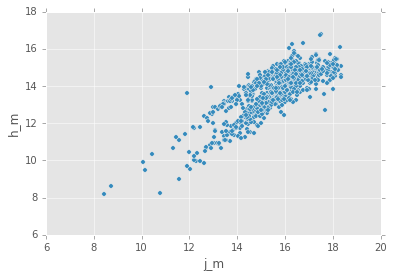

In [38]:
%matplotlib inline
pd_2mass.plot.scatter('j_m', 'h_m')

*****
*****

# Exercises


### Read the data

To start with, read in the two data files representing the master source list and observations source list.  The fields for the two tables are respectively documented in:

- [master_sources](http://cxc.harvard.edu/csc/columns/master.html)
- [obs_sources](http://cxc.harvard.edu/csc/columns/persrc.html)

In [ ]:
master_sources = Table.read('data/cdfs_master_sources.fits')
obs_sources = Table.read('data/cdfs_obs_sources.fits')

**`master_sources`**

Each distinct X-ray source identified on the sky is represented in the catalog by a single "master source" entry and one or more "source observation" entries, one for each observation in which the source has been detected. The master source entry records the best estimates of the properties of a source, based on the data extracted from the set of observations in which the source has been detected.  The subset of fields in our exercise table file are:

Name | Description
------ | ------------
msid  | Master source ID
name  | Source name in the Chandra catalog
ra  | Source RA (deg)
dec | Source Dec (deg)

**`obs_sources`**

The individual source entries record all of the properties about a detection extracted from a single observation, as well as associated file-based data products, which are observation-specific.  The subset of fields in our exercise table file are:

Name | Description
------ | ------------
obsid | Observation ID
obi | Observation interval
targname | Target name
gti_obs | Observation date
flux_aper_b | Broad band (0.5 - 7 keV) flux (erg/cm2/sec)
src_cnts_aper_b | Broad band source counts
ra_b | Source RA (deg)
dec_b | Source Dec (deg)
livetime | Observation duration (sec)
posid | Position ID
theta | Off-axis angle (arcmin)
msid | Master source ID

### Exploring the data
Do the following to explore the two tables:

- Display the data for each table in IPython notebook using the normal way of showing the value of a variable.
- Get a list of the column names for each table.  *Hint*: use `<TAB>` completion to easily discover all the attributes and methods, e.g. type `master_sources.` and then hit the `<TAB>` key.
- Find the length of each table.
- Find the column datatypes for each table.

Normally one displays a table in IPython notebook by entering the variable name in a cell and pressing `shift-Enter`.  In a terminal session the default method is using something like `print(my_table)`.  In both cases the `Table` object prefers to display only a screenful of data to prevent having a zillion lines of output if the table is huge.  If you really want to see all the data you can use the [Table.pprint](http://astropy.readthedocs.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.pprint) method. If you are using a Jupyter notebook interface, try the `show_in_notebook()` method.

- Display all the rows of the `master_sources` table using its `pprint()` method.
- If you are working in a regular terminal window (not IPython notebook), try the `more()` method as well.

### Modifying tables
For our analysis we don't actually need the `obi` (observation interval) column in the `obs_sources` table.

- Remove the `obi` column from the `obs_sources` table.

The `gti_obs` column name is a bit obscure (GTI is a good time interval, FWIW).

- Rename the `gti_obs` column to `obs_date`.

It would be nice to have a count rate in addition to the source counts.

- Add a new column `src_rate_aper_b` which is the source counts divided by observation duration in sec.

Some of the sources have a negative net flux in the broad band

### Looking at the observation source data
For each source detected in an individual observation (in the `obs_sources` table), let's look at the source flux values.

- Use the matplotlib [`hist()`]( http://matplotlib.org/api/pyplot_api.html?highlight=pyplot.hist#matplotlib.pyplot.hist) function to make a histogram of the source fluxes.  Since the fluxes vary by orders of magnitude,
  use the `numpy.log10` to put the fluxes in log space.

- Also make the same plot but using only sources within 4 arcmin of the center.  *HINT*: use a boolean mask to select values of `theta` that are less than 4.0.

### Join the master_sources and obs_sources tables

The `master_sources` and `obs_sources` tables share a common `msid` column. What we now want is to join the master RA and Dec positions and master source names with the individual observations table.

- Use the [table.join()](http://astropy.readthedocs.org/en/stable/table/operations.html#join) function to make a single table called `sources` that has the master RA, Dec, and name included for each observation source.

*HINT*: the defaults for `keys` and `join_type='inner'`  are correct in this case, so the simplest possible call to `join()` will work!

- *Intermediate*: Is the length of the new `sources` the same as `obs_sources`?  What happened?

- *Advanced*: Make a scatter plot of the RA (x-axis) and Dec (y-axis) difference between the master source position and the observation source position.  You'll need to use `coordinates`!

### Grouped properties of `sources`

Finally, we can look at the variability properties of sources in the CDFS using the [`group_by()`](http://astropy.readthedocs.org/en/stable/table/operations.html#id2) functionality.  

This method makes a new table in which all the sources with identical master ID are next to each other.

- Make a new table `g_sources` which is the `sources` table grouped by the `msid` key using the `group_by()` method.

The `g_sources` table is just a regular table with all the `sources` in a particular order.  The attribute `g_sources.groups` is an object that provides access to the `msid` sub-groups.  You can access the $i^{th}$ group with `g_sources.groups[i]`.

In addition the `g_sources.groups.indices` attribute is an array with the indicies of the group boundaries.

- Using `np.diff()` find the number of repeat observations of each master sources.  *HINT*: use the indices, Luke.
- Print the 50th group and note which columns are the same for all group members and which are different.  Does this make sense?  In these few observations how many different target names were provided by observers?

#### Aggregation

The real power of grouping comes in the ability to create aggregate values for each of the groups, for instance the mean flux for each unique source.  This is done with the [`aggregate()`](http://astropy.readthedocs.org/en/stable/table/operations.html#aggregation) method, which takes a function reference as its input.  This function must take as input an array of values and return a single value.

Aggregate returns a new table that has a length equal to the number of groups.

- Compute the mean of all columns for each unique source (i.e. each group) using `aggregate` and the `np.mean` function.  Call this table `g_sources_mean`.
- Notice that aggregation cannot form a mean for certain columns and these are dropped from the output.  Use the `join()` function to restore the `master_sources` information to `g_sources_mean`.

In [2]:
import pandas as pd

In [12]:
%time pd_t = pd.read_csv("data/TgasSource_000-000-000.csv.gz")

CPU times: user 2.92 s, sys: 118 ms, total: 3.04 s
Wall time: 3.04 s


[Back to top](#Tables-introduction)

In [13]:
%time at_t = Table.read("data/TgasSource_000-000-000.csv.gz", format='ascii.csv')

CPU times: user 4.55 s, sys: 274 ms, total: 4.83 s
Wall time: 4.83 s


In [14]:
pd_t.columns

Index(['hip', 'tycho2_id', 'solution_id', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac',
       'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac',
       'astrometric_delta_q', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_primary_flag',
       'astrometric_relegation_factor', 'astrometric_weight_al',
       'astrometric_weight_ac', 'astrometric_priors_used',
       'matched_observations', 'duplicated_source',
       'scan_direction_strength_k1', 'scan_direction_strength_k2',
       'scan_direction_stren

In [19]:
df_list = []
for i in range(16):
    df_list.append(pd.read_csv('data/TgasSource_000-000-{:03d}.csv.gz'.format(i)))

tt = pd.concat(df_list, ignore_index=True)
del df_list  # free up a bunch of RAM...

In [21]:
tt.shape

(2057050, 59)

<IPython.core.display.Javascript object>


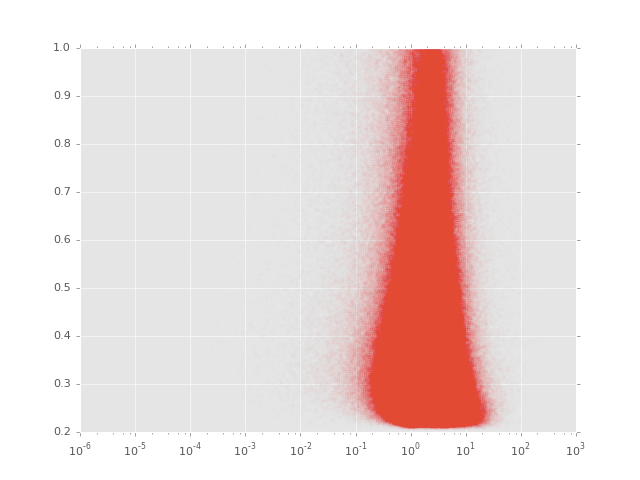

In [22]:
plt.plot(tt.parallax, tt.parallax_error, '.', alpha=0.005)
plt.xscale('log')
plt.show()

In [24]:
from astropy.table import vstack
at_list = []
for i in range(16):
    at_list.append(Table.read('data/TgasSource_000-000-{:03d}.csv.gz'.format(i), format="ascii.csv"))
at = vstack(at_list)
del at_list

In [26]:
at.info

/Users/pickering/miniconda3/envs/py35/lib/python3.5/site-packages/astropy/table/column.py:263: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__eq__(other)


<Table masked=True length=2057050>
             name              dtype   n_bad 
----------------------------- ------- -------
                          hip   int64 1963415
                    tycho2_id   str12   93635
                  solution_id   int64       0
                    source_id   int64       0
                 random_index   int64       0
                    ref_epoch float64       0
                           ra float64       0
                     ra_error float64       0
                          dec float64       0
                    dec_error float64       0
                     parallax float64       0
               parallax_error float64       0
                         pmra float64       0
                   pmra_error float64       0
                        pmdec float64       0
                  pmdec_error float64       0
                  ra_dec_corr float64       0
             ra_parallax_corr float64       0
                 ra_pmra_corr float64       0

<IPython.core.display.Javascript object>


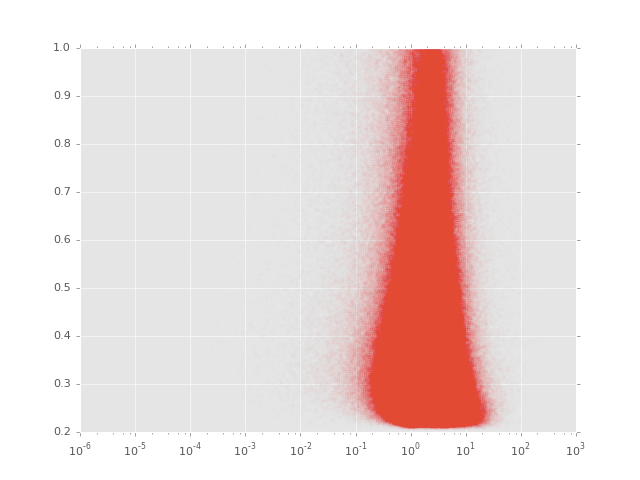

In [28]:
plt.plot(at['parallax'], at['parallax_error'], '.', alpha=0.005)
plt.xscale('log')
plt.show()